# REDIS BENCHMARK

## config REDIS

In [52]:
#import redis
import redis
r = redis.Redis()
#empties all previous keys
r.flushall()
#check there is no key anymore
r.keys()

[]

## Import dataset in redis

In [53]:
# import dataset
import pandas as pd
df = pd.read_csv("netflix_titles.csv")
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [54]:
with r.pipeline() as pipe:
    for index, row in df.iterrows():
        pipe.hmset(row.show_id,row.to_dict())
    pipe.execute()


<ipython-input-54-e0ba77c3f72e>:3: DeprecationWarning: Pipeline.hmset() is deprecated. Use Pipeline.hset() instead.
  pipe.hmset(row.show_id,row.to_dict())


## Benchmark function

In [55]:
import time 
import matplotlib.pyplot as plt 
import numpy as np 


def benchmark(commands):
    """
    Function to run run_nb times a list of command and display stats and boxplot
    """
    run_nb=10
    run_times=[]
    medians=[]
    for command_idx,command_name in enumerate(commands):
        run_time=[]
        for run in range(run_nb):
            start_time=time.time()
            commands[command_name]()
            end_time=time.time()
            run_time.append(end_time-start_time)
        
        median=np.median(np.array(run_time))
        std=np.std(np.array(run_time))
        mean=np.mean(np.array(run_time))
        print("---- "+str(command_idx)+": "+command_name+" ----")
        print('average time:'+str(mean)+'\n median:'+str(median)+'\n std:'+str(std))
        run_times.append(run_time)
        medians.append(median)
   
    plt.boxplot(run_times)
    plt.ylim(0, np.max(medians)*2)
    plt.show()




## Get a whole line

---- 0: hget same line ----
average time:0.0002897146224975586
 median:0.00024509429931640625
 std:0.0004439781112290251
---- 1: hget random line ----
average time:0.00026602911949157715
 median:0.0002529621124267578
 std:0.00017940224462143872


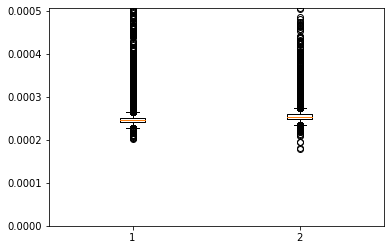

In [220]:
import random

def hgetall():
    r.hgetall('s7392')
    

def hgetallrandom():
    i=random.randint(1,7787)
    r.hgetall('s'+str(i))

benchmark({'hget same line':hgetall,'hget random line':hgetallrandom})



### With pipeline?

In [202]:

run_nb=1
batch=10000
start_time=time.time()
for run in range (run_nb):
    with r.pipeline() as pipe:
        for i in range(batch):
            r.hgetall('s7392')
        pipe.execute()
        
mean=(time.time()-start_time)/(run_nb*batch)

print(mean)

0.0002807837963104248


## get show id

---- 0: get s1 ----
average time:0.00015975871086120605
 median:0.00011968612670898438
 std:0.000497947532219968
---- 1: get s4000 ----
average time:0.00011732738018035888
 median:0.00011110305786132812
 std:0.00018866653273962524
---- 2: get s7000 ----
average time:0.00011274054050445557
 median:0.00011110305786132812
 std:4.605054127215788e-05


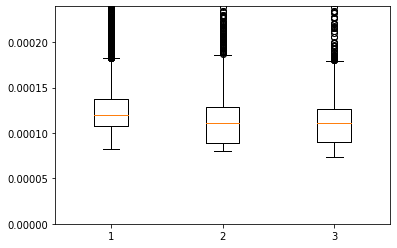

In [221]:
def hmget1():
    r.hmget('s1','show_id')
def hmget4000():
    r.hmget('s4000','show_id')
def hmget7000():
    r.hmget('s7000','show_id')

benchmark({'get s1':hmget1,'get s4000':hmget4000,'get s7000':hmget7000})

## Set a line

<ipython-input-222-52aa2a8b906d>:2: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  r.hmset('test',next(df.iterrows())[1].to_dict())


---- 0: hmset ----
average time:0.003097118258476257
 median:0.002730131149291992
 std:0.001903121778900204


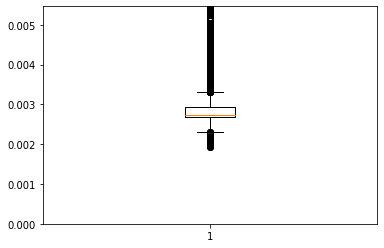

In [222]:

def hmset():
        r.hmset('test',next(df.iterrows())[1].to_dict())
benchmark({'hmset':hmset})
#r.keys()

## With Pipeline?

In [223]:

run_nb=10
batch=1000
start_time=time.time()
for run in range (run_nb):
    with r.pipeline() as pipe:
        for i in range(batch):
            r.hmset('test',next(df.iterrows())[1].to_dict())
        pipe.execute()
        
mean=(time.time()-start_time)/(run_nb*batch)

print(mean)

<ipython-input-223-ed277b0f8646>:7: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  r.hmset('test',next(df.iterrows())[1].to_dict())


0.003294803190231323


## Key exist? 

---- 0: s1 ----
average time:0.001210165023803711
 median:0.00016701221466064453
 std:0.003109073540187422
---- 1: s2 ----
average time:0.0007622718811035156
 median:0.00010645389556884766
 std:0.001934697827458227


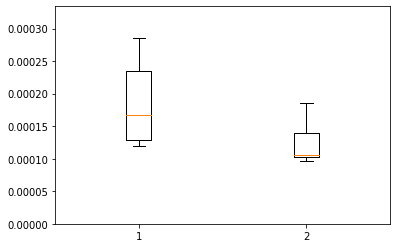

In [48]:
def exist1():
    r.exists('s1')
def exist7000():
    r.exists('s7000')
    
benchmark({'s1':exist1,'s2':exist7000})

---- 0: dir exists head ----
average time:1.08746497631073
 median:1.088720679283142
 std:0.042682785663858074
---- 1: dir exists middle ----
average time:0.6500355243682862
 median:0.6523808240890503
 std:0.026576931001824122
---- 2: dir exists end ----
average time:1.0630942344665528
 median:1.0606114864349365
 std:0.03508737631590128


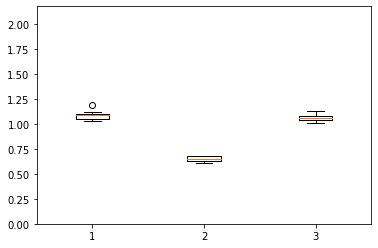

In [57]:
def director_exists_head():
    for show_id in r.scan_iter():
        if (r.hget(show_id,'director')==b'David Raynr'):
            return
            
def director_exists_middle():
    for show_id in r.scan_iter():
        if (r.hget(show_id,'director')==b'Lance Daly'):
            return
            
def director_exists_end():
    for show_id in r.scan_iter():
        if (r.hget(show_id,'director')==b'Emma Hatherley'):
            return
            
director_exists_head()
director_exists_middle()
director_exists_end()

benchmark({'dir exists head':director_exists_head,'dir exists middle':director_exists_middle,'dir exists end':director_exists_end})


## INCRBY


In [42]:
print(r.hget("s7001",'release_year'))
r.hincrby("s7001","release_year")
print(r.hget("s7001",'release_year'))

b'2020'
b'2021'


In [47]:

def benchmark_thread(commands):
    """
    Function to run run_nb times a list of command and display stats and boxplot
    """
    
    run_nb=10
    run_times=[]
    medians=[]
    for command_idx,command_name in enumerate(commands):
        run_time=[]
        
        for run in range(run_nb):
            
            start_time=time.time()
            commands[command_name]()
            end_time=time.time()
            run_time.append(end_time-start_time)
        
        median=np.median(np.array(run_time))
        std=np.std(np.array(run_time))
        mean=np.mean(np.array(run_time))
        print("---- "+str(command_idx)+": "+command_name+" ----")
        print('average time:'+str(mean)+'\n median:'+str(median)+'\n std:'+str(std))
        run_times.append(run_time)
        medians.append(median)
   
    plt.boxplot(run_times)
    plt.ylim(0, np.max(medians)*2)
    plt.show()
benchmark({'s1':exist1,'s2':exist7000})

NameError: name 'exist1' is not defined

In [44]:
import logging
import threading
import time
run_nb=1000
client_nb=50


def thread_function(name):
    logging.info("Thread %s: starting", name)
    r = redis.Redis()
    for i in range(run_nb):
        r.hincrby("s7001","release_year")
    logging.info("Thread %s: finishing", name)


threads = list()

for index in range(client_nb):
    logging.info("Main    : create and start thread %d.", index)
    x = threading.Thread(target=thread_function, args=(index,))
    threads.append(x)
    x.start()

for index, thread in enumerate(threads):
    logging.info("Main    : before joining thread %d.", index)
    thread.join()
    logging.info("Main    : thread %d done", index)

19:50:32: Main    : create and start thread 0.
19:50:32: Thread 0: starting
19:50:32: Main    : create and start thread 1.
19:50:32: Thread 1: starting
19:50:32: Main    : create and start thread 2.
19:50:32: Thread 2: starting
19:50:32: Main    : create and start thread 3.
19:50:32: Thread 3: starting
19:50:32: Main    : create and start thread 4.
19:50:32: Thread 4: starting
19:50:32: Main    : create and start thread 5.
19:50:32: Thread 5: starting
19:50:33: Main    : create and start thread 6.
19:50:33: Thread 6: starting
19:50:33: Main    : create and start thread 7.
19:50:33: Thread 7: starting
19:50:33: Main    : create and start thread 8.
19:50:33: Thread 8: starting
19:50:33: Main    : create and start thread 9.
19:50:33: Thread 9: starting
19:50:33: Main    : create and start thread 10.
19:50:33: Thread 10: starting
19:50:33: Main    : create and start thread 11.
19:50:33: Thread 11: starting
19:50:33: Main    : create and start thread 12.
19:50:33: Thread 12: starting
19:50:

19:50:39: Main    : thread 34 done
19:50:39: Main    : before joining thread 35.
19:50:39: Main    : thread 35 done
19:50:39: Main    : before joining thread 36.
19:50:39: Main    : thread 36 done
19:50:39: Main    : before joining thread 37.
19:50:39: Main    : thread 37 done
19:50:39: Main    : before joining thread 38.
19:50:39: Main    : thread 38 done
19:50:39: Main    : before joining thread 39.
19:50:39: Main    : thread 39 done
19:50:39: Main    : before joining thread 40.
19:50:39: Main    : thread 40 done
19:50:39: Main    : before joining thread 41.
19:50:39: Main    : thread 41 done
19:50:39: Main    : before joining thread 42.
19:50:39: Main    : thread 42 done
19:50:39: Main    : before joining thread 43.
19:50:39: Main    : thread 43 done
19:50:39: Main    : before joining thread 44.
19:50:39: Main    : thread 44 done
19:50:39: Main    : before joining thread 45.
19:50:39: Main    : thread 45 done
19:50:39: Main    : before joining thread 46.
19:50:39: Main    : thread 4

In [45]:
print(r.hget("s7001",'release_year'))

b'52021'
